In [1]:
import networkx as nx
import numpy as np
import pandas as pd

def create_tree(current_node, current_depth, max_depth, G):
    if current_depth < max_depth:
        num_children = np.random.randint(1, 6)  # Entre 1 et 5 enfants
        for _ in range(num_children):
            new_node = len(G.nodes)
            G.add_edge(current_node, new_node)
            G.nodes[new_node]['value'] = np.random.random()  # Valeur flottante
            create_tree(new_node, current_depth + 1, max_depth, G)

# Nombre de graphes à générer
num_graphs = 5
# Profondeur maximale de chaque arbre
max_depth = 6
# Catégories pour les étiquettes
categories = ['A', 'B', 'C']

# Liste pour stocker les graphes et leurs étiquettes
graph_data_with_graph_labels = []

# Générer les graphes avec étiquettes globales
for _ in range(num_graphs):
    G = nx.DiGraph()  # Créer un graphe dirigé
    root_node = 0
    G.add_node(root_node)
    G.nodes[root_node]['value'] = np.random.random()
    create_tree(root_node, 0, max_depth, G)
    
    # Ajouter une étiquette globale pour le graphe
    graph_label = np.random.choice(categories)  # Étiquette catégorielle globale pour le graphe
    graph_data_with_graph_labels.append((G, graph_label))

# Afficher le premier graphe et son étiquette globale pour vérification
first_graph_data_with_label = {
    "graph": {
        node: graph_data_with_graph_labels[0][0].nodes[node] for node in graph_data_with_graph_labels[0][0].nodes()
    },
    "label": graph_data_with_graph_labels[0][1]
}

first_graph_data_with_label


{'graph': {0: {'value': 0.02050236287340701},
  1: {'value': 0.8678651375000715},
  2: {'value': 0.34098739526892197},
  3: {'value': 0.6608007688651706},
  4: {'value': 0.9849897227552401},
  5: {'value': 0.295916781029252},
  6: {'value': 0.5202636403391616},
  7: {'value': 0.6236806566706415},
  8: {'value': 0.8197037911692672},
  9: {'value': 0.2363999045183316},
  10: {'value': 0.7099261384477082},
  11: {'value': 0.24629205791183184},
  12: {'value': 0.08912563542340457},
  13: {'value': 0.5004279635397394},
  14: {'value': 0.8490541390331537},
  15: {'value': 0.3896690517014091},
  16: {'value': 0.6334954680489691},
  17: {'value': 0.7343999015758316},
  18: {'value': 0.48610111626823915},
  19: {'value': 0.9186895535228164},
  20: {'value': 0.1599693034782278},
  21: {'value': 0.20526289654351204},
  22: {'value': 0.01739835442125237},
  23: {'value': 0.7144428999719364},
  24: {'value': 0.9040260078670298},
  25: {'value': 0.6777908511707592},
  26: {'value': 0.554864842105385

C:\Users\decroux paul\AppData\Local\Temp\ipykernel_19352\4126667925.py:9: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(tree_to_plot, prog='dot')  # 'dot' est idéal pour les arbres


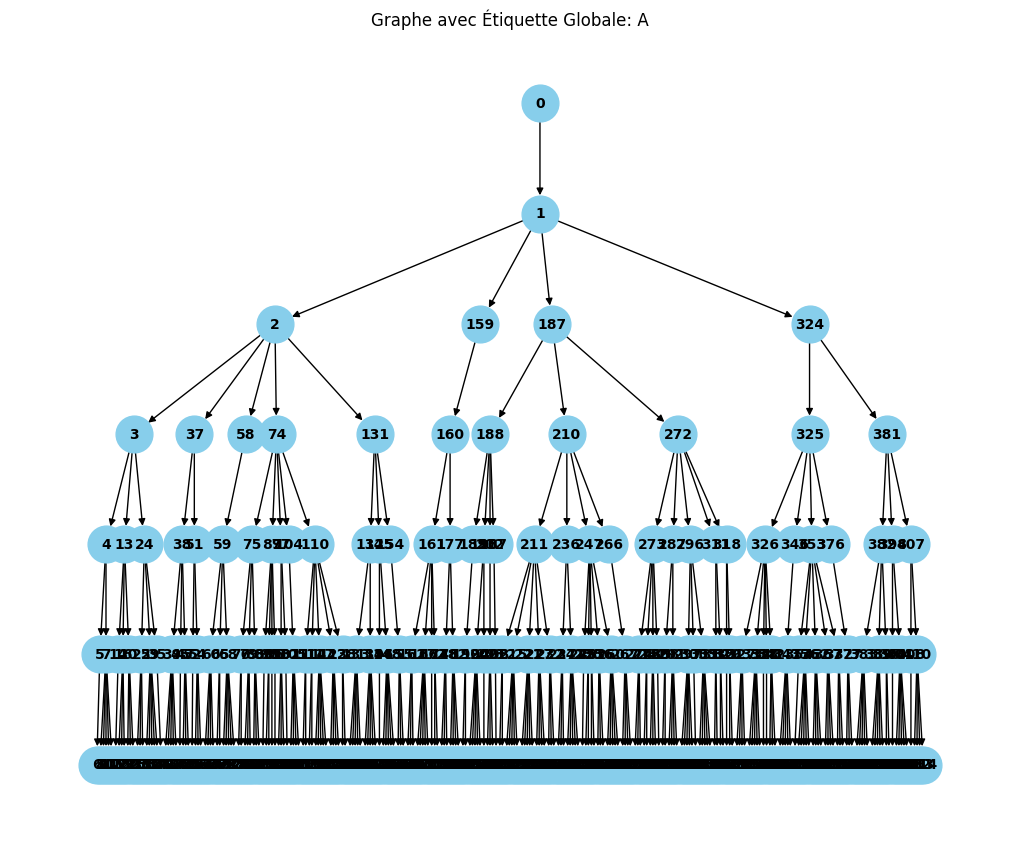

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# Sélectionner le premier graphe pour la visualisation
tree_to_plot = graph_data_with_graph_labels[0][0]

# Utiliser graphviz_layout avec pydot
pos = graphviz_layout(tree_to_plot, prog='dot')  # 'dot' est idéal pour les arbres

# Dessiner le graphe
plt.figure(figsize=(10, 8))  # Augmenter la taille de la figure pour une meilleure clarté
nx.draw(tree_to_plot, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(tree_to_plot, pos, edge_labels=nx.get_edge_attributes(tree_to_plot, 'weight'))
plt.title(f"Graphe avec Étiquette Globale: {graph_data_with_graph_labels[0][1]}")
plt.show()


In [3]:
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader



In [4]:
import torch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F

# Création des objets Data de PyTorch Geometric
data_list = []
for tree, label in graph_data_with_graph_labels:
    edge_index = torch.tensor(list(tree.edges()), dtype=torch.long).t().contiguous()
    x = torch.tensor([tree.nodes[n]['value'] for n in tree.nodes()], dtype=torch.float).view(-1, 1)
    y = torch.tensor([categories.index(label)], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index, y=y)
    data_list.append(data)

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)  # Agrège les caractéristiques à l'échelle du graphe
        return x


# Initialisation du modèle
model = GCN(num_node_features=1, num_classes=len(categories))  # 1 feature par nœud, nombre de classes

# Entraînement et évaluation (à adapter selon vos besoins)


In [5]:
import torch
from torch_geometric.data import DataLoader

# Définir le critère de perte et l'optimiseur
criterion = torch.nn.CrossEntropyLoss()  # Perte pour la classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Optimiseur avec un taux d'apprentissage de 0.01

# Préparer le DataLoader
train_loader = DataLoader(data_list, batch_size=10, shuffle=True)

# Boucle d'entraînement
def train():
    model.train()  # Mettre le modèle en mode entraînement
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()  # Réinitialiser les gradients
        out = model(data)  # Passer les données à travers le modèle
        loss = criterion(out, data.y)  # Calculer la perte
        loss.backward()  # Propager les gradients
        optimizer.step()  # Mettre à jour les poids
        total_loss += loss.item()
    return total_loss / len(train_loader)  # Retourner la perte moyenne

# Entraîner pour un nombre défini d'époques
epochs = 100
for epoch in range(epochs):
    loss = train()
    print(f'Epoch {epoch+1}, Loss: {loss}')


c:\Users\decroux paul\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 1.0799602270126343
Epoch 2, Loss: 1.0551707744598389
Epoch 3, Loss: 1.0294009447097778
Epoch 4, Loss: 1.0095653533935547
Epoch 5, Loss: 0.9841914176940918
Epoch 6, Loss: 0.9627718925476074
Epoch 7, Loss: 0.9524898529052734
Epoch 8, Loss: 0.9282616376876831
Epoch 9, Loss: 0.921798825263977
Epoch 10, Loss: 0.9065672159194946
Epoch 11, Loss: 0.8853643536567688
Epoch 12, Loss: 0.8732479810714722
Epoch 13, Loss: 0.8594009280204773
Epoch 14, Loss: 0.852067768573761
Epoch 15, Loss: 0.8408262133598328
Epoch 16, Loss: 0.8278082013130188
Epoch 17, Loss: 0.8227939605712891
Epoch 18, Loss: 0.8085921406745911
Epoch 19, Loss: 0.8005815744400024
Epoch 20, Loss: 0.7804244756698608
Epoch 21, Loss: 0.789125919342041
Epoch 22, Loss: 0.7693316340446472
Epoch 23, Loss: 0.7698939442634583
Epoch 24, Loss: 0.7617648839950562
Epoch 25, Loss: 0.7548954486846924
Epoch 26, Loss: 0.740703284740448
Epoch 27, Loss: 0.7557177543640137
Epoch 28, Loss: 0.755252480506897
Epoch 29, Loss: 0.7332960963249207

In [6]:
# Assurez-vous que le modèle est en mode évaluation
model.eval()

# Sélectionner le graphe pour la prédiction (ici, nous prenons le premier graphe)
data = data_list[0]

# Exécuter le modèle sur le graphe sélectionné pour obtenir la prédiction
with torch.no_grad():  # Désactive le calcul des gradients pour les prédictions
    out = model(data)
    pred_label_idx = out.argmax(dim=1)  # Obtenir l'indice de la classe prédite
    pred_label = categories[pred_label_idx.item()]  # Convertir l'indice en étiquette

# Afficher la prédiction
print(f"Étiquette réelle: {categories[data.y.item()]}")
print(f"Étiquette prédite: {pred_label}")


Étiquette réelle: A
Étiquette prédite: A
